<h1> Analytic continuation of Hubbard dimer<h1> 

In this notebook, we illustrate how to conduct analytic continuation using `adapol`. We took the strongly correlated hubbard dimer model as an example. On the one hand, it serves as a nontrivial test case which features several closely spaced peaks that could be very challenging. On the other hand, its modest size allows for exact diagonalization, enabling the calculation of ground truth results for rigorous benchmarking. This example was also used as benchmark tests in [this](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.104.165111) and [this](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.107.075151) paper.

Let us consider the following Hamiltonian:
$$
\hat H = \hat H_0 + \hat H_1,
$$
where
$$
H_0 = -t \sum_{\sigma \in \{\uparrow, \downarrow\}} \left( \hat c_{0\sigma}^\dagger \hat c_{1\sigma} + \hat c_{1\sigma}^\dagger \hat c_{0\sigma} \right) 
-\mu \left( \hat n_{0\uparrow} + \hat n_{0\downarrow} + \hat n_{1\uparrow} + \hat n_{1\downarrow} \right),
$$
$$
\begin{aligned}
    H_1 =& (U+U_a) \hat n_{0\uparrow} \hat n_{0\downarrow} + (U-U_a) \hat n_{1\uparrow} \hat n_{1\downarrow} \\
& - \frac U 2 \left( \hat n_{0\uparrow} + \hat n_{0\downarrow} + \hat n_{1\uparrow} + \hat n_{1\downarrow} \right) + h \left( \hat n_{0\uparrow} - \hat n_{0\downarrow} + \hat n_{1\uparrow} - \hat n_{1\downarrow} \right)\\
&+ \mu_a \left( \hat n_{0\uparrow} + \hat n_{0\downarrow} - \hat n_{1\uparrow} - \hat n_{1\downarrow} \right)+ h_a \left( \hat n_{0\uparrow} - \hat n_{0\downarrow} - \hat n_{1\uparrow} + \hat n_{1\downarrow} \right),
\end{aligned}
$$
Here $\hat n_{i\sigma} = \hat c_{i\sigma}^\dagger \hat c_{i\sigma}$ is the number operator.

The parameters are taken as follows:

In [1]:
t = 1.0
mu = 0.7
h = 0.3
U_a = 0.5
mu_a = 0.2
h_a = 0.03
beta = 25.0
U = 5.0

Using `triqs`, we can construct the Hamiltonian and obtain the Green's function and spectral function through exact diagonalization:

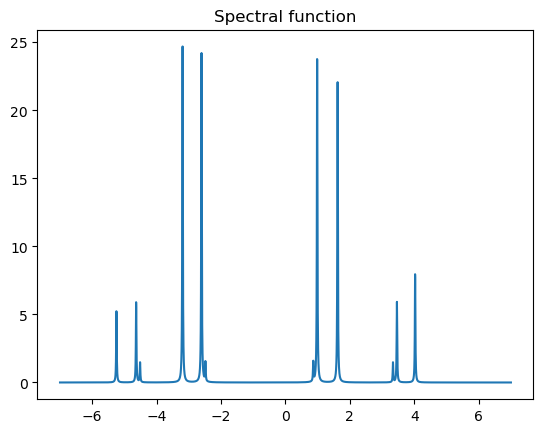

In [2]:
from triqs.operators import c, c_dag,n
from triqs.atom_diag import AtomDiag, atomic_g_w
from itertools import product

f_ops = [(sn,on) for sn, on in product(('up','down'),range(2))]
H_0 = - t * (c_dag('up', 0) * c('up', 1) + c_dag('up', 1) * c('up', 0) )
H_0 += - t * (c_dag('down', 0) * c('down', 1) + c_dag('down', 1) * c('down', 0) )
H_0 += - mu * (n('up', 0) + n('down', 0)) - mu * (n('up', 1) + n('down', 1))

H_1 = (U + U_a) * (n('up', 0) * n('down', 0) ) + (U - U_a) * (n('up', 1) * n('down', 1) )
H_1 -= (U/2.0) * (n('up', 0) + n('down', 0)  + n('up', 1) + n('down', 1) )
H_1 += h * (n('up', 0) - n('down', 0) + n('up', 1) - n('down', 1) )
H_1 += mu_a * (n('up', 0) + n('down', 0) - n('up', 1) - n('down', 1) )
H_1 += h_a * (n('up', 0) - n('down', 0) - n('up', 1) + n('down', 1) )

H = H_0 + H_1
ad = AtomDiag(H, f_ops)

import matplotlib.pyplot as plt
import numpy as np
gf_struct = [('down',2),('up',2)] # fix the bug in the old version by changing orb_names to len(orb_names).
G_w = atomic_g_w(ad, beta, gf_struct, (-7, 7), 4000, 0.01)
Tr_G_w = G_w['up'][0,0] + G_w['down'][0,0] + G_w['up'][1,1] + G_w['down'][1,1]
wmesh = np.array([w.value for w in Tr_G_w.mesh])
plt.plot(wmesh,  -np.imag(Tr_G_w.data)/np.pi)
plt.title("Spectral function")
plt.show()

Let us also construct the Matsubara Green's function data:

In [3]:
from triqs.atom_diag import atomic_g_iw
G_iw = atomic_g_iw(ad, beta, gf_struct, 500)
TrG_iw = G_iw['up'][0,0] + G_iw['down'][0,0] + G_iw['up'][1,1] + G_iw['down'][1,1]
iwmesh = np.array([iw.value.value for iw in TrG_iw.mesh])

Let us first show how to conduct analytic continuation through the `anacont` function:

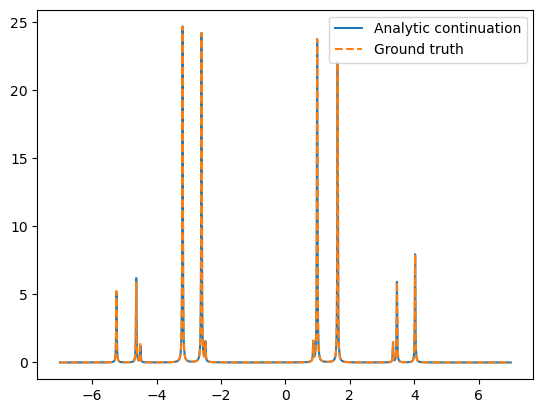

In [4]:
from adapol import anacont
func, fitting_error, pol, weight  = anacont( TrG_iw.data ,  iwmesh , Np = 12)
Spec_approx = -np.imag(func(wmesh+0.01*1j)[:,0,0])/np.pi
plt.plot(wmesh,  Spec_approx) 
plt.plot(wmesh,  -np.imag(Tr_G_w.data)/np.pi,  "--",2)
plt.legend(["Analytic continuation", "Ground truth"])
plt.show()

Next let's see how to conduct analytic continuation through the triqs interface:

optimization finished with fitting error 4.792e-15


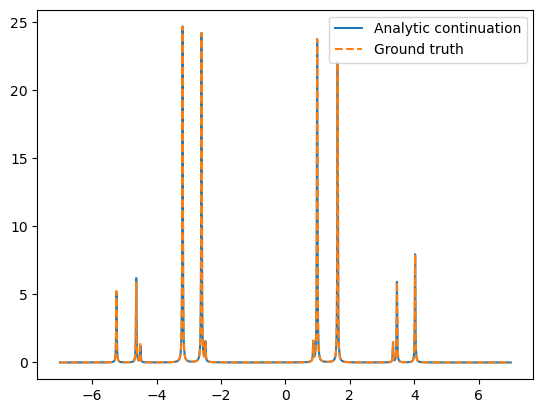

In [5]:
from adapol.anacont import anacont_triqs
func  = anacont_triqs( TrG_iw , Np = 12)
Spec_approx2 = -np.imag(func(wmesh+0.01*1j)[:,0,0])/np.pi
plt.plot(wmesh,  Spec_approx2) 
plt.plot(wmesh,  -np.imag(Tr_G_w.data)/np.pi,  "--",2)
plt.legend(["Analytic continuation", "Ground truth"])
plt.show()